In [6]:
import perceval as pcvl
import numpy as np  

# Create the circuit

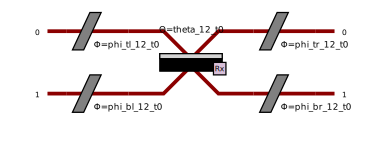

In [7]:
def U_ij_t(i : int , j : int, t : int = 0):
    """Returns the unitary acting on mode i and j."""
    return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
            .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

U_12 = U_ij_t(1, 2)
pcvl.pdisplay(U_12)

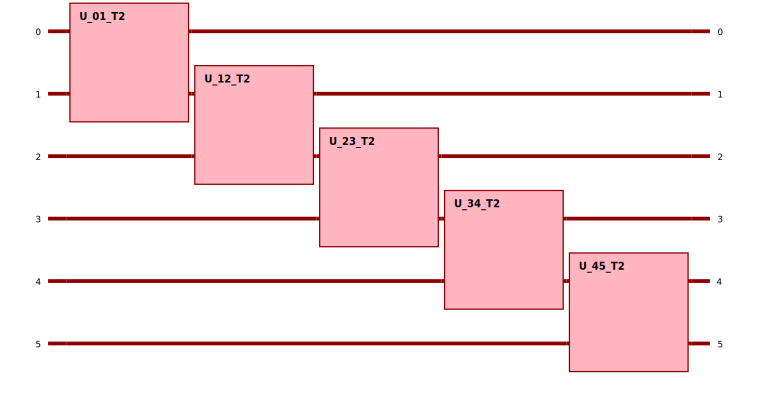

In [8]:
def full_layer(n : int, t : int = 0, _overlapping : bool = False):
    layer = pcvl.Circuit(n)
    if _overlapping:
        for i in range(n-1):
            layer = layer.add(i, U_ij_t(i, (i+1), t))
    else:
        if n % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range((n)//2):
            layer = layer.add(2*i, U_ij_t(i, i+1, t))
    return layer

layer = full_layer(6, 2, True)
pcvl.pdisplay(layer)

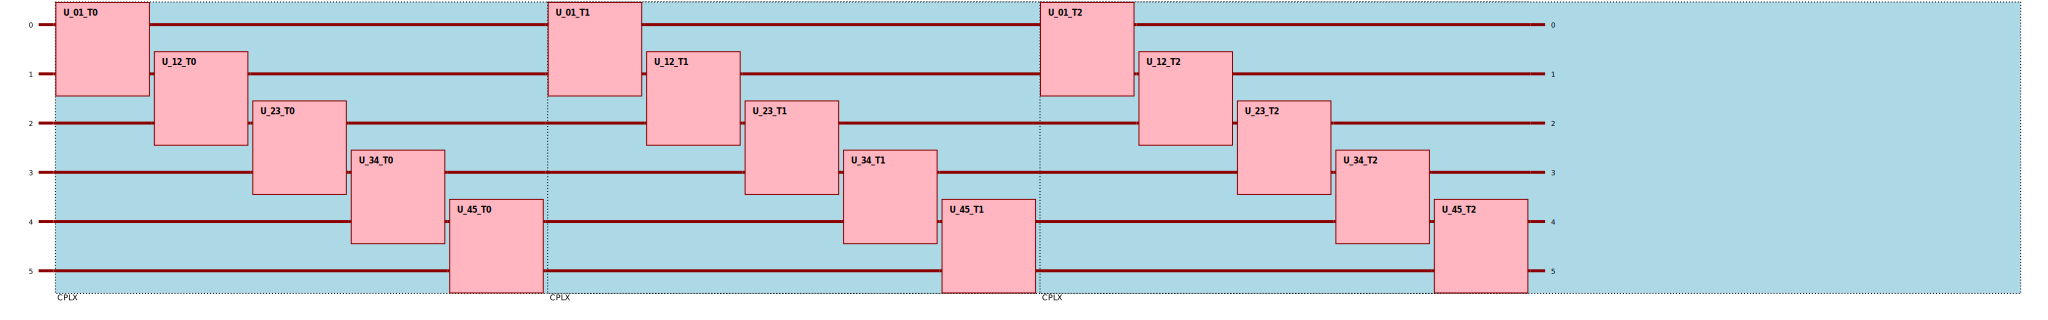

In [9]:
def create_circuit(n, t, _overlapping=False):
    main_circuit = pcvl.Circuit(n)
    for t in range(t):
        main_circuit = main_circuit.add(0, full_layer(n, t, _overlapping), merge=False)
    return main_circuit

# Example usage:
m = 6  # Number of modes
t = 3  # Number of times to repeat the layers
circuit = create_circuit(m, t, _overlapping=True)
pcvl.pdisplay(circuit, recursive=True)


# Set the parameters to the array

In [10]:
# I have 5 parameters to set per circuit layer (theta, phi_tl, phi_bl, phi_tr, phi_br)
# Let't generate a random matrix: (t, 5)

import numpy as np

def generate_parameter_matrix(t, num_parameters):
    # Randomly generate a matrix of size t x num_parameters
    # This can be adjusted to generate parameters based on specific criteria
    return np.random.rand(t, num_parameters)*2*np.pi # Random dataset of angles

t = 10  # Number of timesteps
num_parameters = 5  # Number of parameters per layer
parameter_matrix = generate_parameter_matrix(t, num_parameters)
parameter_matrix

matrix = np.array([[1,2], [3,4]])
print(matrix)
matrix.flatten()

[[1 2]
 [3 4]]


array([1, 2, 3, 4])

In [11]:
#Let's set the parameters of the circuit to the values in the matrix

parameter_matrix = generate_parameter_matrix(t, (m-1)*5)
print(parameter_matrix.shape)

def set_circuit_parameters(circuit, parameter_matrix):
    # Flatten the parameter matrix to match the list of parameters
    flattened_params = parameter_matrix.flatten() # [[1,2], [3,4]] -> [1,2,3,4]
    # Get the parameters from the circuit
    params = circuit.get_parameters()

    # Assert that the lengths match
    assert len(params) == len(flattened_params), f"The number of parameters {len(params)} in the circuit does not match the size of the matrix {len(flattened_params)}."

    # Set the values of the parameters
    for param, value in zip(params, flattened_params):
        param.set_value(value)

set_circuit_parameters(circuit, parameter_matrix)
print(circuit.get_parameters())
pcvl.pdisplay(circuit, recursive=True)

(10, 25)


AssertionError: The number of parameters 75 in the circuit does not match the size of the matrix 250.

# Get the expectation values

In [12]:
backend = pcvl.BackendFactory.get_backend("SLOS")
backend.set_circuit(circuit)
backend.set_input_state(pcvl.BasicState([8]*6))
backend.prob_distribution().keys()

AssertionError: All parameters must be defined to compute numeric unitary matrix

In [13]:
def calculate_mode_expectations(prob_distribution):
    # Initialize a list to store the expectation values for each mode
    # Assuming the first key in the dictionary represents the state format
    first_key = next(iter(prob_distribution.keys()))
    num_modes = len(first_key)  # Determine the number of modes from the FockState
    expectations = [0.0 for _ in range(num_modes)]

    # Iterate over the states and their probabilities
    for state, probability in prob_distribution.items():
        # Directly use the photon numbers from the FockState
        photon_numbers = state

        # Accumulate the expectation values for each mode
        for mode in range(num_modes):
            expectations[mode] += photon_numbers[mode] * probability

    return expectations

# Example usage
prob_distribution = backend.prob_distribution()
expectation_values = calculate_mode_expectations(prob_distribution)
print("Expectation values for each mode:", expectation_values)


KeyError: None

In [ ]:

print(backend.all_prob(pcvl.BasicState([0]*6)))
print(backend.prob_amplitude(pcvl.BasicState([2]*6)))  #note that it's the amplitude !
print(backend.prob_amplitude(pcvl.BasicState([0]*6)))
print(backend.probability(pcvl.BasicState([2]*6)))

# Making it a class

In [76]:
import perceval as pcvl
import numpy as np

class PhotonicCircuitSimulator:
    def __init__(self, m, t, overlapping=False):
        self.m = m  # Number of modes
        self.t = t  # Number of time layers
        self.overlapping = overlapping
        self.circuit = self.create_circuit()

    def U_ij_t(self, i, j, t=0):
        """Returns the unitary acting on mode i and j."""
        return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
                .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
                .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
                .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
                .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
                .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

    def full_layer(self, t=0):
        """Generate one full time layer"""
        layer = pcvl.Circuit(self.m)
        if self.overlapping:
            for i in range(self.m - 1):
                layer = layer.add(i, self.U_ij_t(i, (i + 1), t))
        else:
            if self.m % 2 != 0:
                print("WARNING: Number of modes is not even; last mode will be ignored.")
            for i in range(self.m // 2):
                layer = layer.add(2 * i, self.U_ij_t(2 * i, 2 * i + 1, t))
        return layer

    def create_circuit(self):
        """Creates a circuit with t layers."""
        circuit = pcvl.Circuit(self.m)
        for t in range(self.t):
            circuit = circuit.add(0, self.full_layer(t))
        return circuit
    
    def generate_rndm_param_matrix(self):
        """Generates a random parameter matrix of size (t, num_parameters)."""
        num_parameters = len(self.circuit.get_parameters())
        return np.random.rand(t, num_parameters//t)*2*np.pi # Random dataset of angles

    def set_circuit_parameters(self, parameter_matrix):
        """Set the parameters of the circuit to the values in the matrix.
        
        Args:
            parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

        Description:
            The parameter matrix is flattened to match the list of parameters.
            The parameters are set in the order they appear in the circuit.
        """
        flattened_params = parameter_matrix.flatten()
        params = self.circuit.get_parameters()
        assert len(params) == len(flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
        for param, value in zip(params, flattened_params):
            param.set_value(value)

    def calculate_mode_expectations(self, input_state : pcvl.BasicState = None):

        if input_state is None:
            print("WARNING: No input state provided. Using the vacuum state.")
            input_state = pcvl.BasicState([0] * self.m)

        backend = pcvl.BackendFactory.get_backend("SLOS")
        backend.set_circuit(self.circuit)
        backend.set_input_state(input_state)
        prob_distribution = backend.prob_distribution()

        expectations = [0.0 for _ in range(self.m)]
        for state, probability in prob_distribution.items():
            for mode in range(self.m):
                expectations[mode] += state[mode] * probability
        return expectations

# Example usage
m = 6
t = 100
simulator = PhotonicCircuitSimulator(m, t, overlapping=True)

# Set parameters
param_matrix = simulator.generate_rndm_param_matrix()
simulator.set_circuit_parameters(param_matrix)

# Calculate expectations
input_state = pcvl.BasicState([4]*(m-2) + [0]*2)
expectation_values = simulator.calculate_mode_expectations(input_state)
print("Expectation values for each mode:", expectation_values)


Expectation values for each mode: [1.767946361656972, 2.600894637134805, 3.6966245560949513, 3.051264569604818, 2.546193036103541, 2.3370768394057175]
